In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
device = torch.device("cuda:0")


In [2]:
with open("datasets/tinyShakespeare.txt", "r") as f:
    load = f.read()
print(load[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [3]:
texttoint = {elm: n for n, elm in enumerate(set(load))}
inttotext = {n:elm for n, elm in enumerate(set(load))}
dataset = [texttoint[c] for c in load]

vocab_size = len(texttoint)
sequence_length = 20

sequences = torch.tensor([dataset[i:-sequence_length+i-1] for i in range(sequence_length+1)]).T
inputs = sequences[2000:, :-1]
labels = sequences[2000:, -1]
val_inputs = sequences[:2000, :-1]
val_labels = sequences[:2000, -1]

# Attention Block - Scaled dot product attention

A very effective system that can find correlations between tokens is the attention block <br><br>

It takes in a series of tokens: input (sequence_length, embedding_size)<br>
we call this layer "attention head", you can have one head of self attention or many heads with different weights. <br> 
and computes the dot products with 3 sets of weights, called "keys", "queries" and "values" of size (emb_size, head_size) <br>
 
After this operation you have three tensors of size (sequence_length, head_size) <br>
you compute the similarity matrix (sequence_length, sequence_length) by multiplying keys with transposed queries. <br><br>

The next step is to tril (transform to lower triangular) and softmax the similarity matrix, and a scaling by sqrt(head_size) <br>
(This is why its called scaled dot product attention) <br>
Following is a dot product with the values. The output will be (sequence_length, head_size) <br>

This block has roughly a complexity of O(sequence_length^2) witch is sub optimal for long sequence lengths, so we use sligthly different attention blocks for that<br>

In [4]:
class Attention(nn.Module):  
    def __init__(self, emb_size=10, head_size=128):
        super(Attention, self).__init__()
        self.head_size = head_size

        self.keys = nn.Linear(emb_size, head_size)
        self.queries = nn.Linear(emb_size, head_size)
        self.values = nn.Linear(emb_size, head_size) 
        self.rvalues = nn.Linear(head_size, emb_size)

    def forward(self, x, mask=False):
        k = self.keys(x)
        q = self.queries(x)
        v = self.values(x)

        similarity = k @ q.transpose(-2, -1)/(self.head_size**0.5)
        if mask: similarity[torch.tril(torch.ones_like(similarity)) == 0] = float("-inf")
        similarity = torch.softmax(similarity, dim = 1)
        
        attention = similarity @ v 
        attention = self.rvalues(attention)
        return attention


class FullyConnected(nn.Module):  
    def __init__(self, in_size, out_size, hidden_size=256, n_layers=2):
        super(FullyConnected, self).__init__()

        self.fc1 = nn.Linear(in_size, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)])
        self.fc2 = nn.Linear(hidden_size, out_size)
    
    def forward(self, x):
        x = F.gelu(self.fc1(x))
        for fc in self.fcx:
            x = x + F.gelu(fc(x)) # Residual connection not present in the original paper, but it helps with convergence
        x = self.fc2(x)
        return x


class Block(nn.Module): 
    def __init__(self, emb_size=32, head_size=256):
        super().__init__()
        self.emb_size = emb_size
        self.head_size = head_size

        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.posemb = nn.Embedding(sequence_length, emb_size)
        self.prenorm1 = nn.LayerNorm(emb_size)
        self.att = Attention(emb_size, head_size)
        self.prenorm2 = nn.LayerNorm(emb_size)
        self.fc = FullyConnected(emb_size, emb_size)

        self.fcout = nn.Linear(emb_size, vocab_size)

    def forward(self, x):          
        x = self.embedding(x) + self.posemb(torch.arange(x.size(1)).to(x.device))
        x = self.prenorm1(x)
        x = x + self.att(x) 
        x = self.prenorm2(x)
        x = x + self.fc(x)
        x = self.fcout(x)
    
        return x[:, -1]
    
device = torch.device("cuda:0")
model = Block().to(device)

epochs = 100
batch_size = 8192
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) # everything in the forward pass happens in the model class
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(loss.item())
    
    with torch.no_grad():
        pred = model(val_inputs.to(device))
        loss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(loss.item())

4.375614166259766
3.400297164916992
3.172821044921875
2.985860824584961
2.853022336959839
2.735029697418213
2.641831398010254
2.5774788856506348
2.5115652084350586
2.4725892543792725


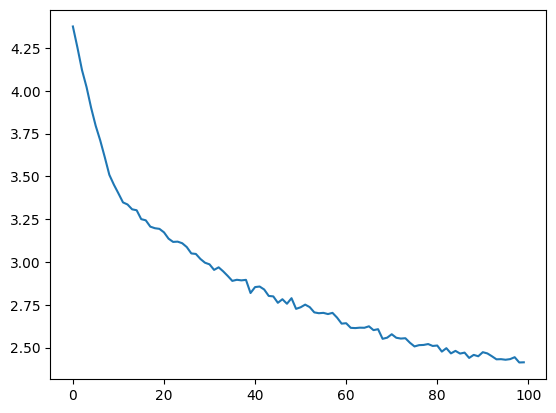

In [5]:
plt.plot(lossi[:]) # 1.45

In [6]:
string = "           \nKING RICHARD I"
print(string, end="")

with torch.no_grad():
    for _ in range(300):
        X = torch.tensor([texttoint[s] for s in string[-sequence_length:]]).long().view(1, -1).to(device)
        pred = model.forward(X)
        string += inttotext[torch.multinomial(F.softmax(pred, dim=1), 1).item()]
        print(string[-1], end="")


           
KING RICHARD I bamik
HACP ther corahesllandfroald. ing thy imas falt lie.

LEBLI$Whig.

M
W:
We ARESit, youreverid go-e, ist datimseave so liis tie!
HE
M'd IOINIO:
UI nour le arld ayek somn.

Why bofin thit hiveru ebe thor ou?

IOxe herad ord,
HAxULONer'l cithag wime monkelsey mot,

Was'd prd andeanenghe, thit wo

# Transformers 

Transformers consist of attention blocks in sequence, with residual connections 

In [8]:
class Block(nn.Module): 
    def __init__(self, emb_size, head_size=256):
        super().__init__()
        self.emb_size = emb_size
        self.head_size = head_size

        self.prenorm1 = nn.LayerNorm(emb_size)
        self.att = Attention(emb_size, head_size)
        self.prenorm2 = nn.LayerNorm(emb_size)
        self.fc = FullyConnected(emb_size, emb_size)

    def forward(self, x):          
        x = self.prenorm1(x)
        x = x + self.att(x) 
        x = self.prenorm2(x)
        x = x + self.fc(x)
    
        return x

# Everything is the same upto here. Now we will create a transformer class that combines the blocks
class Transformer(nn.Module): 
    def __init__(self, emb_size=32, n_blocks=4, vocab_size=1000):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.posemb = nn.Embedding(sequence_length, emb_size)
        
        self.blocks = nn.ModuleList([Block(emb_size) for _ in range(n_blocks)])
        self.LinOut = nn.Linear(emb_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x) + self.posemb(torch.arange(x.size(1)).to(x.device))

        for block in self.blocks:
            x = block(x)
            
        x = self.LinOut(x)
        return x[:, -1]
    

device = torch.device("cuda:0")
model = Transformer(vocab_size=vocab_size).to(device)

epochs = 10000
batch_size = 512
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) # everything in the forward pass happens in the model class
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(loss.item())

    with torch.no_grad():
        pred = model(val_inputs.to(device))
        loss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(loss.item())

4.447756290435791
2.093792676925659
1.7966108322143555
1.75531804561615
1.7765017747879028
1.7442829608917236
1.4980069398880005
1.5491397380828857
1.6340588331222534
1.5432945489883423


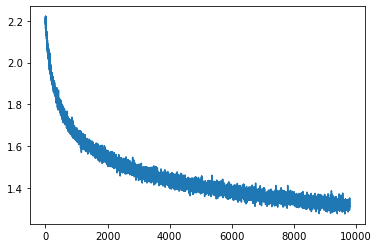

In [ ]:
plt.plot(lossi[200:])

# Results
As you can see we can get really good loss with the transformer, this architecture scales well up to GPT3.5 level performance with enough high quality data

In [9]:
print("Millions of parameters: ", round(sum(p.numel() for p in model.parameters() if p.requires_grad)/1000000, 2))
print([p.numel() for p in model.parameters() if p.requires_grad])

Millions of parameters:  0.73
[2080, 640, 32, 32, 8192, 256, 8192, 256, 8192, 256, 8192, 32, 32, 32, 8192, 256, 65536, 256, 65536, 256, 8192, 32, 32, 32, 8192, 256, 8192, 256, 8192, 256, 8192, 32, 32, 32, 8192, 256, 65536, 256, 65536, 256, 8192, 32, 32, 32, 8192, 256, 8192, 256, 8192, 256, 8192, 32, 32, 32, 8192, 256, 65536, 256, 65536, 256, 8192, 32, 32, 32, 8192, 256, 8192, 256, 8192, 256, 8192, 32, 32, 32, 8192, 256, 65536, 256, 65536, 256, 8192, 32, 2080, 65]


In [22]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, head_size, n_heads):
        super().__init__()
        assert emb_size%n_heads == 0
        
        self.n_heads = n_heads
        self.heads = nn.ModuleList([Attention(emb_size//n_heads, head_size) for _ in range(n_heads)])

    def forward(self, x):  # (B, S, E)
        assert x.dim() == 3
        emb_size = x.shape[-1]
        step = emb_size//self.n_heads

        result = []
        for n, head in enumerate(self.heads):
            result.append(head(x[:, :, n*step: (n+1)*step]))
        return torch.cat(result, -1)
    
class Block(nn.Module): 
    def __init__(self, emb_size, head_size=256, n_heads=8):
        super().__init__()
        self.emb_size = emb_size
        self.head_size = head_size

        self.prenorm1 = nn.LayerNorm(emb_size)
        self.att = MultiHeadAttention(emb_size, head_size, n_heads)
        self.prenorm2 = nn.LayerNorm(emb_size)
        self.fc = FullyConnected(emb_size, emb_size)

    def forward(self, x):          
        x = self.prenorm1(x)
        x = x + self.att(x) 
        x = self.prenorm2(x)
        x = x + self.fc(x)
    
        return x
    

device = torch.device("cuda:0")
model = Transformer(emb_size=256, vocab_size=vocab_size).to(device)

epochs = 2000
batch_size = 512
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) # everything in the forward pass happens in the model class
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(loss.item())

    with torch.no_grad():
        pred = model(val_inputs.to(device))
        loss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(loss.item())

4.197526931762695
2.2983429431915283
2.0127177238464355
2.012798547744751
1.8582326173782349
1.809157133102417
1.7844947576522827
1.5545670986175537
1.7259559631347656
1.7270854711532593
